Test implementation of a Variational Autoencoder

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, losses

from keras.datasets import mnist
from keras.models import Model

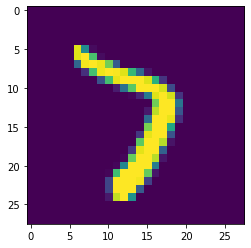

In [87]:
(x_train, _), (x_test, y_test) = mnist.load_data()

def preprocess_images(images, discrete=True):
    # Normalize and make into tensor
    images = images.reshape((images.shape[0], 28, 28, 1)) /255.

    if discrete:
        # Round pixel values to 0 or 1. Allows use of cross entropy loss?
        return np.where(images > .5, 1.0, 0.0).astype('float32')
    else:
        # No discretization of pixel values
        return images.astype('float32')

# Look at random image (before binarization)
img_nbr = np.random.randint(0, len(x_train)+1)
plt.imshow(x_train[img_nbr, :, :])
plt.show()

x_train = preprocess_images(x_train) # shape: (nbr_images, 28, 28, 1)
x_test = preprocess_images(x_test)

In [88]:
# Do we need to batch and shuffle the data?
# Maybe in we dont use the fit() function, we need to do it manually

train_size = x_train.shape[0]
batch_size = 32 # Size of batches in gradient update / training step?
test_size = x_test.shape[0]
print(x_test.shape)

train_dataset = (tf.data.Dataset.from_tensor_slices(x_train).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).shuffle(test_size).batch(batch_size))

tf.print(test_dataset)

(10000, 28, 28, 1)
<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


Alternative functional approach

https://keras.io/examples/generative/vae/


In [89]:
# Define model
# https://www.tensorflow.org/tutorials/generative/cvae

class VAE(Model):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = keras.Sequential([
            layers.InputLayer(input_shape=(28, 28, 1)),

            layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            layers.Flatten(),

            # 2D latent space -> 2D mean, 2D var ->
            # mean1, mean2, log_var1, log_var2 -> 2 + 2
            layers.Dense(latent_dim + latent_dim),
        ])

        self.decoder = keras.Sequential([
            # Point z sampled from distrs. will be 2D
            layers.InputLayer(input_shape=(latent_dim,)),

            # BIG dense that takes 2d z input
            layers.Dense(units=7*7*32, activation='relu'),

            # Reshape into tensor
            layers.Reshape(target_shape=(7, 7, 32)),

            # Transp. Conv: padding same? no upsampling?
            # Pads the input so output is same dim?
            layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=(2, 2), padding='same',
                activation='relu'),
            layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=(2, 2), padding='same',
                activation='relu'),

            # Last layer, no activation / linear?
            layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=(1, 1), padding='same'),
        ])

    # Decorator: turns py code into graph
    # Use for computationally expensive functions
    @tf.function
    def sample(self, eps=None):
        # Sample 100 random z?
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(
            self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        # Returns a z sampled from N(mean, var)
        
        # Added stuff to deal with batches?
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        
        eps = tf.random.normal(shape=(batch, dim))
        return mean + eps * tf.exp(logvar * .5) # mu + eps * std

    def decode(self, z, apply_sigmoid=False):
        # Decode latent z into image
        # apply_sigmoid: outputs pixel values [0, 1]
        logits = self.decoder(z) # logits vals: (-inf, inf)?
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    # Needed for summary
    def call(self, x):
        mean, logvar = self.encode(x)
        sampled_z = self.reparameterize(mean, logvar)
        decoded_img = self.decode(sampled_z)
        return decoded_img
    
    def summary(self):
        # Uses 'call' to initialize something in TF backend 
        # that allows for 'summary'
        x = keras.Input(shape=(28, 28, 1))
        model = Model(inputs=[x], outputs=self.call(x))
        return model.summary()
        


In [90]:
# Defining loss function

# learning rate: 1e-4
optimizer = tf.keras.optimizers.Adam(1e-4)

# Returns logarithm of normal pdf w. 
# mean, logvar for each value in 'sample'
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)

    # log(norm_pdf(sample; mean, var))
    values = -.5 * (logvar + log2pi + 
    (sample - mean)**2 * tf.exp(-logvar))

    # 'values' consists of log pdf in both latent x- and y-directions
    # 'reduce_sum' sums these up to one value
    return tf.reduce_sum(values, axis=raxis)


def compute_loss(model, x):
    # Compute ELBO loss w.r.t a sample x (or batch?)
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    # Loss between input & output (reconstruction). Binary cross entropy
    # indep. for each pixel?
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=x_logit, labels=x)
    
    log_px_z = -tf.reduce_sum(cross_ent, axis=[1,2,3])
    log_pz = log_normal_pdf(z, 0., 0.)
    log_qz_x = log_normal_pdf(z, mean, logvar)

    # 'mean' to approx. expectation
    return -tf.reduce_mean(log_px_z + log_pz - log_qz_x)


@tf.function
def train_step(model, x, optimizer):
    # Computes gradients and updates weights

    # TODO: learn how gradient tape works
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [91]:
# Model training

epochs = 10
latent_dim = 8
nbr_examples_to_generate = 16

# constant random latent vector
# Used for showing samples during training?
random_vector_for_generation = tf.random.normal(
    shape=[nbr_examples_to_generate, latent_dim])

model = VAE(latent_dim)

model.summary() # Doesnt specity the layers within "sequential"?

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_79 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential_54 (Sequential)      (None, 16)           55696       input_79[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_split_13 (TensorFlo [(None, 8), (None, 8 0           sequential_54[0][0]              
__________________________________________________________________________________________________
tf_op_layer_Shape_16 (TensorFlo [(2,)]               0           tf_op_layer_split_13[0][0]       
_______________________________________________________________________________________

In [92]:
def generate_images(model, test_dataset, test_sample=None):
    # Generates and plots 16 images.
    # Specify which samples though 'test_sample',
    # else random are picked from dataset
    
    if test_sample is not None:
        mean, logvar = model.encode(test_sample)
    else:
        # Pick 16 random images to generate
        assert batch_size >= nbr_examples_to_generate

        for test_batch in test_dataset.take(1): # 'take' picks a random batch
            sample = test_batch[0:nbr_examples_to_generate, :, :, :] # pick 'nbr_ex..' samples
            
        mean, logvar = model.encode(sample)
        
    z = model.reparameterize(mean, logvar)
    samples = model.sample(z)
    fig = plt.figure(figsize=(4, 4))
    
    # plot sampled images
    for i in range(samples.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(samples[i, :, :, 0])
        plt.axis('off')
    
    plt.show()

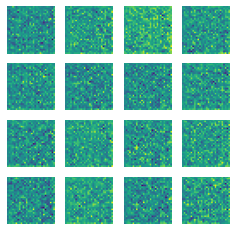

In [93]:
generate_images(model, test_dataset)

In [94]:
# Training
import time
from IPython import display
progbar = tf.keras.utils.Progbar(len(train_dataset))

for epoch in range(1, epochs+1):
    start_time = time.time()
    
    for i, training_batch in enumerate(train_dataset):
        train_step(model, training_batch, optimizer)
        progbar.update(i)
        
    end_time = time.time()
    
    loss = tf.keras.metrics.Mean()
    
    for test_batch in test_dataset:
        loss(compute_loss(model, test_batch))
    
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch {}/{}, Test ELBO: {}, time for epoch: {:.1f}s'.format(
        epoch, epochs, elbo, end_time - start_time))

Epoch 10/10, Test ELBO: -102.3921890258789, time for epoch: 49.1s


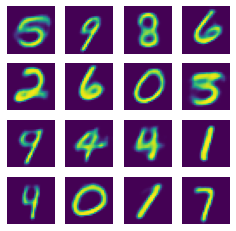

In [99]:
generate_images(model, train_dataset)